In [1]:
# general imports
import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 18})

In [2]:
# Load Ar39 Data
import numpy as np

ar39_file = os.path.join("..", "data", "Ar39_PE_in_15_60.csv")
muon_file = os.path.join("..", "data", "LowEnergyMuons_PE_in_15_60.csv")

ar39  = pd.read_csv(ar39_file, index_col=False)
ar39 = ar39[ar39.columns[1:]]
muons = pd.read_csv(muon_file, index_col=False)
muons = muons[muons.columns[1:]]

print("[Info] Loaded {} Ar39 decays, with maximum {} PE detected".format(len(ar39), ar39.pedetected.max()))
print("[Info] Loaded {} Muons, with maximum {} PE detected".format(len(muons), muons.pedetected.max()))

[Info] Loaded 138701 Ar39 decays, with maximum 60 PE detected
[Info] Loaded 1241 Muons, with maximum 60 PE detected


In [3]:
# Remove test data for later eval
n_train_mu, n_train_ar = 241, 100000
muons_test, muons_train = muons.iloc[:n_train_mu, :], muons.iloc[n_train_mu:, :]
ar39_test, ar39_train = ar39.iloc[:n_train_ar, :], ar39.iloc[n_train_ar:, :]
print("[Info] Muon Train {}, Test {}".format(len(muons_train), len(muons_test)))
print("[Info] Ar39 Train {}, Test {}".format(len(ar39_train), len(ar39_test)))

[Info] Muon Train 1000, Test 241
[Info] Ar39 Train 38701, Test 100000


In [4]:
def undersample_argon(ar39_df, number_of_instances=1000, augment_from_pe=35, augmentation_nr=5,
                      skip_first_cols=2, nslices=72):
    bins = np.linspace(0, 61, 62)
    bin_cont, bin_edges, _ = plt.hist(ar39_df.pedetected, bins=bins, density=True, label="1Ar39", edgecolor='w')
    # compute the nr of samples for each PE value,
    # to undersample ar39 keeping the same distribution
    avail_instances_per_pe = np.array([len(ar39_df[ar39_df.pedetected==pe]) for pe in range(61)])
    nr_ar_samples_per_pe = np.array(np.where(np.ceil(bin_cont*number_of_instances)<=avail_instances_per_pe, np.ceil(bin_cont*number_of_instances), 0), dtype=int)
    # Introduce a small bias on instances with "high" PE value
    # to avoid to have just a few samples (e.g. 30,40,50,60 PE)
    scaled_ar39 = pd.DataFrame()
    for pe in range(1, 61):
        if pe > augment_from_pe:
            nr_instances = augmentation_nr
        else:
            nr_instances = nr_ar_samples_per_pe[pe]
        scaled_ar39 = pd.concat([scaled_ar39, ar39_df[ar39_df.pedetected==pe].iloc[:nr_instances]])
    AA = scaled_ar39.iloc[:, skip_first_cols:skip_first_cols+nslices].to_numpy()
    np.random.shuffle(AA)    # to avoid order by PE
    return pd.DataFrame(AA)

def augment_muons_by_roll(muon_df, augmentation_factor=1, skip_first_cols=2, nslices=72):
    X = muon_df.iloc[:, skip_first_cols:skip_first_cols+nslices].to_numpy()
    for roll in np.array(np.linspace(0, 72, augmentation_factor+1)[:-1], dtype='int'):
        if roll==0:
            XX = X
        else:
            XX = np.concatenate([XX, np.roll(X, roll, axis=1)])
    return pd.DataFrame(XX)

[Info] The Augmented Muons dataset has 1000 instances
[Info] The Scaled Ar39 dataset has 1054 instances


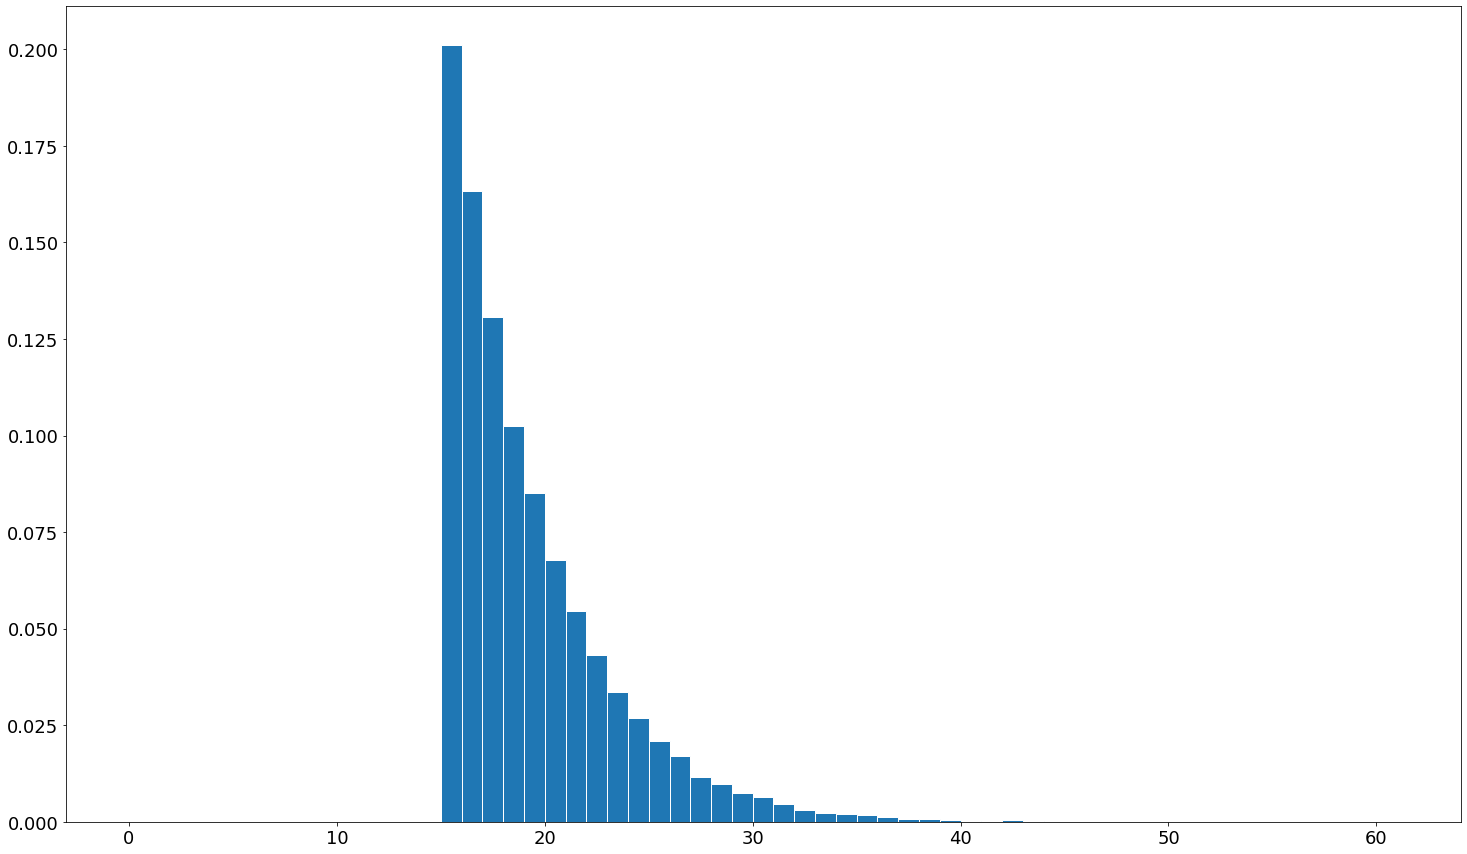

In [5]:
# Augment Muons
muon_data = augment_muons_by_roll(muons_train, augmentation_factor=1)
print("[Info] The Augmented Muons dataset has {} instances".format(len(muon_data)))
# Undersample Ar39
ar39_data = undersample_argon(ar39_train, len(muon_data), augment_from_pe=35, augmentation_nr=5)
print("[Info] The Scaled Ar39 dataset has {} instances".format(len(ar39_data)))

In [6]:
# function to compute the std deviation of active slices based on NPE
def stddev_idslices_fun(row):
    # given an array of aquisitions, it return the std of activated slices
    # it create a populaion of slice ids, and compute stddev on them
    id_population = [item for id_list in [[i] * int(row.iloc[i]) for i in range(len(row))] for item in id_list]
    if id_population:    # check if the list of slice ids is not empty
        return np.std(id_population)
    else:
        return -1

# function to produce quadrant-based features in a parametric way
def produce_quadrant_features(df, nslices=72, nshiftings=4, quadrant_width=36):
    # split aquisitions in K "shifted" quadrant
    # by construction, there are 72 slices
    # we set quadrant_width = nslices // 2 because 
    # we know that the spread is within 15 slices
    shift = nslices // nshiftings   # derived
    assert(len(df.columns) == nslices)
    # create quadrants
    df_quadrants = []
    for i_shift in range(nshiftings):
        assert(i_shift*shift < nslices)
        quadrant = df.iloc[:, i_shift*shift:i_shift*shift + quadrant_width]
        if i_shift*shift + quadrant_width >= nslices:
            quadrant = pd.concat([quadrant, df.iloc[:, :i_shift*shift + quadrant_width - nslices]], axis=1)
        df_quadrants.append(quadrant)
    # compute stddev and meanPE for each quadrant
    for quadrant in df_quadrants:
        quadrant["stdslices"] = quadrant.apply(stddev_idslices_fun, axis=1)
        quadrant["meanpe"] = quadrant.apply(lambda row: row[:quadrant_width].mean(), axis=1)
    # aggregate the features in a single dataset
    features = pd.DataFrame()
    for i, quadrant in enumerate(df_quadrants):
        features = pd.concat([features, quadrant[["stdslices", "meanpe"]]], axis=1)
    features.columns = ["{}_{}".format(col, j) for j in range(len(df_quadrants)) for col in ["stdslices", "meanpe"]]
    return features

# function to produce quad-based features for multiple configurations
def produce_datasets_for_various_quandrant_features(muon_data, ar39_data, nshiftings, widths):
    muon_datasets, ar39_1_datasets = [], []
    for nshifting, width in zip(nshiftings, widths):
        muon_datasets.append(produce_quadrant_features(muon_data, nshiftings=nshifting, quadrant_width=width))
        print("[Info] Computed quadrant features wt nshifting={}, width={} for Muons".format(nshifting, width))
        ar39_1_datasets.append(produce_quadrant_features(ar39_data, nshiftings=nshifting, quadrant_width=width))
        print("[Info] Computed quadrant features wt nshifting={}, width={} for Ar39".format(nshifting, width))
    return muon_datasets, ar39_1_datasets

In [7]:
nshiftings = [1, 2, 4]
widths = [72, 54, 36]
muons_datasets, ar39_1_datasets = produce_datasets_for_various_quandrant_features(muon_data, ar39_data, nshiftings, widths)

[Info] Computed quadrant features wt nshifting=1, width=72 for Muons
[Info] Computed quadrant features wt nshifting=1, width=72 for Ar39


/home/luigi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/luigi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[Info] Computed quadrant features wt nshifting=2, width=54 for Muons
[Info] Computed quadrant features wt nshifting=2, width=54 for Ar39
[Info] Computed quadrant features wt nshifting=4, width=36 for Muons
[Info] Computed quadrant features wt nshifting=4, width=36 for Ar39


# Optimize DTree on raw input

In [8]:
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
import time

init = time.time()

muon_features, ar39_features = muon_data, ar39_data
# Prepare data for training
muon_features["y"] = 1
ar39_features["y"] = 0
data = pd.concat([muon_features, ar39_features], axis=0)
X, y = data.iloc[:, :-1], data.iloc[:, -1]
X = np.array(X)
y = np.array(y)

print("[Info] Tune criterion")
parameters = {'criterion': ['gini', 'entropy']}        

# Conduct Parameter Optmization With Pipeline
# Create a grid search object
clf = GridSearchCV(DecisionTreeClassifier(max_depth=8, min_samples_leaf=1), 
                   param_grid = parameters, 
                   scoring='precision', n_jobs=2, cv=5)

# Fit the grid search
clf.fit(X, y)
print(clf.best_params_)
print(clf.best_score_)

print("\n[Info] Tune Depth, Min Samples leaf")
parameters = {'max_depth': [2, 4, 6, 8, 12],
             'min_samples_leaf': [1, 10, 30, 50, 100]}        

# Conduct Parameter Optmization With Pipeline
# Create a grid search object
clf = GridSearchCV(DecisionTreeClassifier(criterion='entropy'), 
                   param_grid = parameters, 
                   scoring='precision', n_jobs=2, cv=5)

# Fit the grid search
clf.fit(X, y)
print(clf.best_params_)
print(clf.best_score_)

print("\n[Info] 5 fold CV")
# Use Cross Validation To Evaluate Model
CV_Result = cross_val_score(clf, X, y, cv=5, scoring='precision')
print("Results: {}".format(CV_Result))
print("Mean Score: {}, Std Dev: {}".format(CV_Result.mean(), CV_Result.std()))

print("Elapsed time {}".format(time.time() - init))

[Info] Tune criterion
{'criterion': 'entropy'}
0.6864936707872371

[Info] Tune Depth, Min Samples leaf
{'max_depth': 2, 'min_samples_leaf': 1}
0.7014291325255562

[Info] 5 fold CV
Results: [0.8        0.63414634 0.66315789 0.68965517 0.75      ]
Mean Score: 0.70739188172281, Std Dev: 0.060046416951626824
Elapsed time 4.771615743637085


# Optimize DTree on quadrant features

In [9]:
init = time.time()

models = []
for i, (muon_features, ar39_features) in enumerate(zip(muons_datasets, ar39_1_datasets)):
    print("[Info] Dataset {}".format(i))
    # Prepare data for training
    muon_features["y"] = 1
    ar39_features["y"] = 0
    data = pd.concat([muon_features, ar39_features], axis=0)
    X, y = data.iloc[:, :-1], data.iloc[:, -1]
    X = np.array(X)
    y = np.array(y)

    print("  [Info] Tune criterion")
    parameters = {'criterion': ['gini', 'entropy']}        

    # Conduct Parameter Optmization With Pipeline
    # Create a grid search object
    clf = GridSearchCV(DecisionTreeClassifier(max_depth=8, min_samples_leaf=1), 
                       param_grid = parameters, 
                       scoring='precision', n_jobs=2, cv=5)

    # Fit the grid search
    clf.fit(X, y)
    best_criterion = clf.best_params_["criterion"]


    print("  [Info] Tune Depth, Min Samples leaf")
    parameters = {'max_depth': [2, 4, 6, 8, 12],
                 'min_samples_leaf': [1, 10, 30, 50, 100]}        

    # Conduct Parameter Optmization With Pipeline
    # Create a grid search object
    clf = GridSearchCV(DecisionTreeClassifier(criterion='entropy'), 
                       param_grid = parameters, 
                       scoring='precision', n_jobs=2, cv=5)

    # Fit the grid search
    clf.fit(X, y)
    best_depth = clf.best_params_["max_depth"]
    best_minsamples = clf.best_params_["min_samples_leaf"]

    # Use Cross Validation To Evaluate Model
    print("  [Result] Best model: criterion: {}, depth: {}, min samples leaf: {}".format(best_criterion, best_depth, best_minsamples))
    clf = DecisionTreeClassifier(criterion=best_criterion, max_depth=best_depth, min_samples_leaf=best_minsamples)
    clf.fit(X, y)
    models.append(clf)
    CV_Result = cross_val_score(clf, X, y, cv=5, scoring='precision')
    print("  [Eval 5CV] Mean Score: {:.4f}, Std Dev: {:.4f}".format(CV_Result.mean(), CV_Result.std()))

    print("\n  [Info] Elapsed time {:.2f}".format(time.time() - init))
    print()

[Info] Dataset 0
  [Info] Tune criterion
  [Info] Tune Depth, Min Samples leaf
  [Result] Best model: criterion: entropy, depth: 2, min samples leaf: 1
  [Eval 5CV] Mean Score: 0.8195, Std Dev: 0.0233

  [Info] Elapsed time 0.36

[Info] Dataset 1
  [Info] Tune criterion
  [Info] Tune Depth, Min Samples leaf
  [Result] Best model: criterion: entropy, depth: 2, min samples leaf: 1
  [Eval 5CV] Mean Score: 0.8287, Std Dev: 0.0237

  [Info] Elapsed time 1.03

[Info] Dataset 2
  [Info] Tune criterion
  [Info] Tune Depth, Min Samples leaf
  [Result] Best model: criterion: gini, depth: 2, min samples leaf: 1
  [Eval 5CV] Mean Score: 0.8030, Std Dev: 0.0284

  [Info] Elapsed time 1.74



# Test model

In [122]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix as cv

def test_model(muon_features, ar39_features, model, model_name):
    data_template    = "[Info] Dataset with {} features"
    model_template   = "[Info] Model: {}"
    cm_template  = "[Result] Conf. Matrix: TN: {}, FP: {}, FN: {}, TP: {} | TPR: {:.2f}%, FPR: {:.2f}%\n"
    result_template  = "[Result] {}: Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}\n"

    print(data_template.format(len(muon_features.columns)))
    print(model_template.format(model_name))
    # Prepare data for training
    muon_features["y"] = 1
    ar39_features["y"] = 0
    # data preparation
    data = pd.concat([muon_features, ar39_features], axis=0)
    X, y = data.iloc[:, :-1], data.iloc[:, -1]
    X = np.array(X)
    y = np.array(y)
    # evaluation
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    tn, fp, fn, tp = cv(y, y_pred).ravel()
    #print(result_template.format("Test({} Mu, {} Ar)".format(len(muon_features), len(ar39_1_features)),
    #                            accuracy, precision, recall, f1))    
    tpr, fpr = recall*100, fp/(fp+tn)*100
    print(cm_template.format(tn, fp, fn, tp, tpr, fpr))    

In [116]:
# prepare test data
skip_first_cols, nslices = 2, 72
muon_test_data = pd.DataFrame(muons_test.iloc[:, skip_first_cols:skip_first_cols+nslices].to_numpy())
ar39_test_data = pd.DataFrame(ar39_test.iloc[:, skip_first_cols:skip_first_cols+nslices].to_numpy())
# prepare datasets
prom_shiftings = [1, 2, 4]
prom_widths = [72, 54, 36]
muons_test_datasets, ar39_1_test_datasets = produce_datasets_for_various_quandrant_features(muon_test_data, ar39_test_data, prom_shiftings, prom_widths)

[Info] Computed quadrant features wt nshifting=1, width=72 for Muons
[Info] Computed quadrant features wt nshifting=1, width=72 for Ar39


/home/luigi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/luigi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[Info] Computed quadrant features wt nshifting=2, width=54 for Muons
[Info] Computed quadrant features wt nshifting=2, width=54 for Ar39
[Info] Computed quadrant features wt nshifting=4, width=36 for Muons
[Info] Computed quadrant features wt nshifting=4, width=36 for Ar39


In [125]:
for model, muon_features, ar39_1_features in zip(models, muons_test_datasets, ar39_1_test_datasets):
    test_model(muon_features, ar39_1_features, model, "DTree\n{}".format(model.get_params()))

[Info] Dataset with 3 features
[Info] Model: DTree
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}
[Result] Conf. Matrix: TN: 45457, FP: 4543, FN: 93, TP: 148 | TPR: 61.41%, FPR: 9.09%

[Info] Dataset with 5 features
[Info] Model: DTree
{'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}
[Result] Conf. Matrix: TN: 44855, FP: 5145, FN: 95, TP: 146 | TPR: 60.58%, FPR: 10.29%

[Info] Dataset with 9 features
[Info] Model: DTree
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 6